In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Template 02
- multi-class - Fashion MNIST dataset (all 60000 images)

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score)

# from utils.helper import fn_plot_confusion_matrix

In [3]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
# Some basic parameters
inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 32

EPOCHS = 500 # number of cycles to run
ALPHA = 0.01 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

# Helper Functions

In [5]:
def fn_plot_labels(train_df : pd.DataFrame,
                   
                test_df : pd.DataFrame):

    '''
    Args:
        train_df (pd.DataFrame): Train Set
        test_df (pd.DataFrame): Test Set

    '''

    plt.figure (figsize=(15, 4))

    plt.subplot(1, 2, 1)

    ax = train_df['label'].value_counts().plot(kind='bar', alpha = 0.6, title = 'Train', color = 'DarkBlue')

    plt.subplot(1, 2, 2)

    ax = train_df['label'].value_counts().plot(kind='bar', alpha = 0.6, title = 'Train', color = 'Orange')

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [6]:
train_df = pd.read_csv('../Datasets/fashion-mnist_train.csv')
test_df = pd.read_csv('../Datasets/fashion-mnist_test.csv')

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [7]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [10]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

## Whats in the data?

In [11]:
# Sample data plot

# plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

# fig = plt.figure(figsize=(15, 12))  # figure size in inches

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

# i = 0

# for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
#     i = i + 1
    
#     image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
#     ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
#     ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
#     ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=16)   # add number (class) of the image
    
#     ax.text(2, 25, class_names[row.iloc[0]], color='r', fontsize=16)   # add name of the image
    
# plt.show()

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [12]:
def fn_split_feature_label(row):

    feature = tf.reshape(row[1:], [28, 28, 1])
    label = row[0]
    return feature, label
#     X_train = train_df.drop('label', axis = 1).to_numpy()
#     y_train = train_df['label'].to_numpy()
    
#     X_test = test_df.drop('label', axis = 1).to_numpy()
#     y_test = test_df['label'].to_numpy()
    
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [13]:
# Make a tensorflow Dataset from pandas dataframe
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

# map a dataset to a function spliting in features and labels
train_ds = tmp_ds.map(fn_split_feature_label)

# get me only one batch of data
train_ds = train_ds.batch(BATCH_SIZE)

# Make a tensorflow Dataset from pandas dataframe
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

# map a dataset to a function spliting in features and labels
test_ds = tmp_ds.map(fn_split_feature_label)

# get me only one batch of data
test_ds = test_ds.batch(BATCH_SIZE)

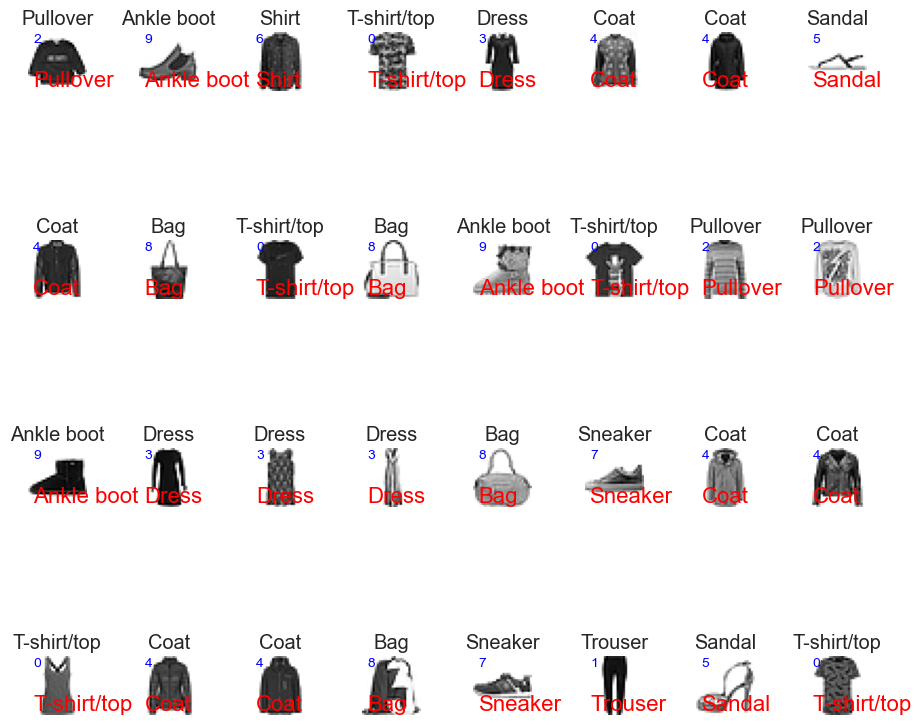

In [14]:
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE // 8, 8, i+1)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        plt.title(class_names[labels[i].numpy()])
        plt.text(2, 4, labels[i].numpy(), color = 'b')
        plt.text(2, 25, class_names[labels[i].numpy()], color = 'r', fontsize=16)
    plt.tight_layout()
    plt.show()

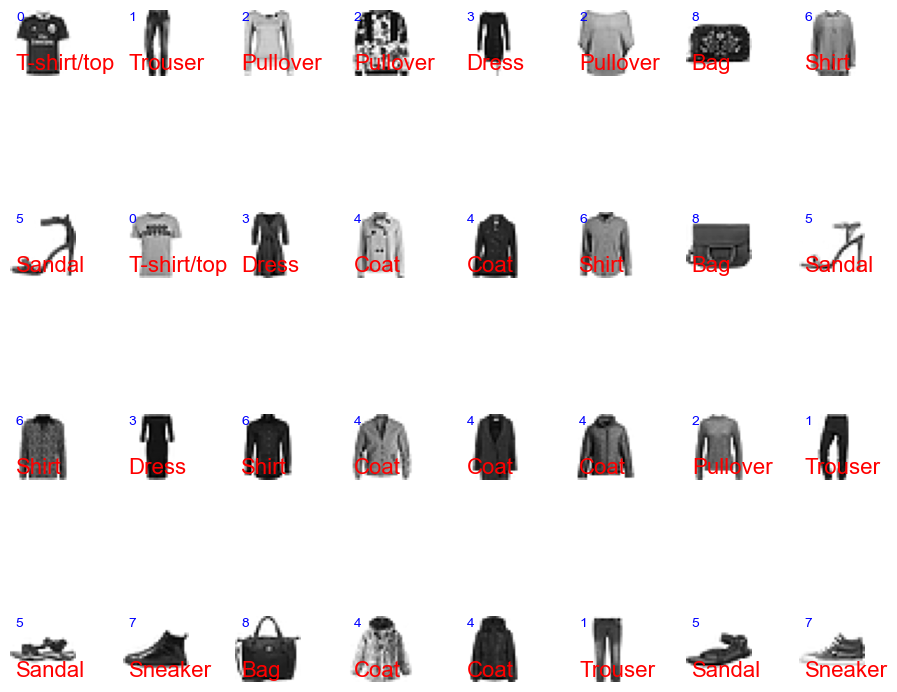

In [15]:
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE // 8, 8, i+1)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        plt.text(2, 4, labels[i].numpy(), color = 'b')
        plt.text(2, 25, class_names[labels[i].numpy()], color='r', fontsize=16)  
    plt.tight_layout()
    plt.show()

# Rescaling

In [16]:
norm_layer = tf.keras.layers.Rescaling(1./255.)

image_batch, labels_batch = next(iter(train_ds))

display(image_batch[0].numpy().max())

norm_ds = train_ds.map(lambda x, y: (norm_layer(x), y))

image_batch, labels_batch = next(iter(norm_ds))

display(image_batch[0].numpy().max())

255

1.0

In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Demo

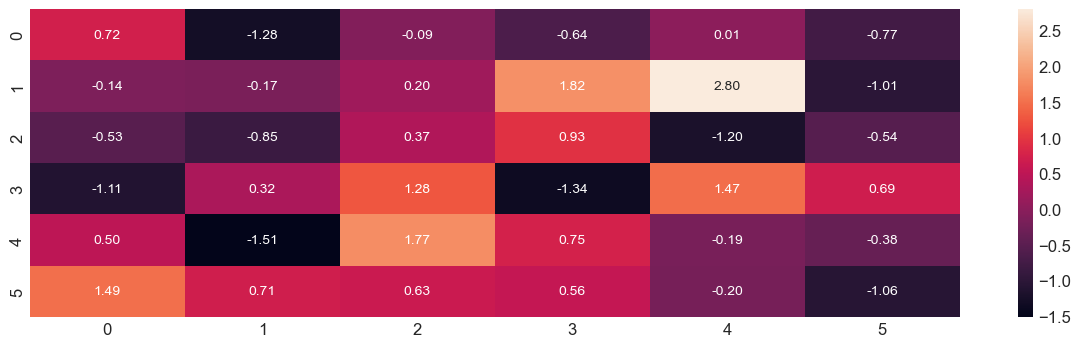

In [18]:
import seaborn as sns
plt.figure(figsize=(15, 4))
input_shape = (1, 6, 6, 1)
X = tf.random.normal(input_shape)
sns.heatmap(X.numpy()[0, :, :, 0], annot=True, fmt=".2f");

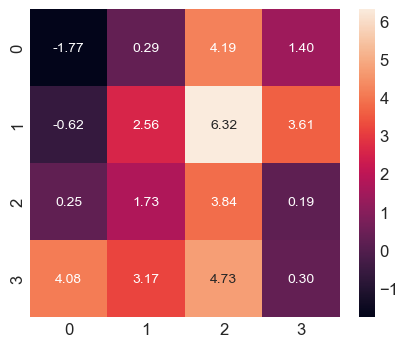

In [19]:
y = tf.keras.layers.Conv2D(1, 3, kernel_initializer=tf.constant_initializer(1.),
                          use_bias=False)(X)
plt.figure(figsize=(5, 4))
sns.heatmap(y.numpy()[0, :, :, 0], annot=True, fmt=".2f");

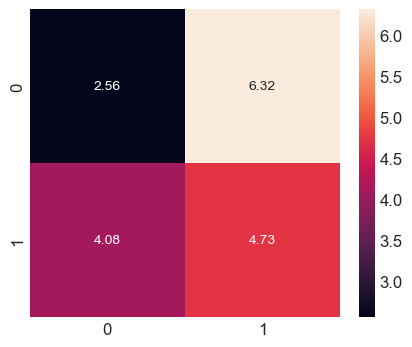

In [20]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid')(y)
plt.figure(figsize=(5, 4))
sns.heatmap(max_pool.numpy()[0, :, :, 0], annot=True, fmt=".2f");

In [21]:
input_shape = (28, 28, 1)
knl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE) # kernel initializer
# Reg 1 : L2 regularization
# knl_reg = tf.keras.regularizers.L2(l2 = 0.005) # kernel regularizer
# Reg 2 : Batch norm + Dropout
dor1 = 0.2
dor2 = 0.25
dor3 = 0.35
dor4 = 0.45
dor5 = 0.55
model = tf.keras.Sequential(name= 'MNIST_Fashion') # instantiate the model

model.add(tf.keras.Input(shape=(input_shape), name='Input')) # input layer
model.add(tf.keras.layers.Rescaling(1./255.)) # rescale the image

### Set 1
model.add(tf.keras.layers.Conv2D(32, (3,3), name='Conv1', kernel_initializer=knl_init, padding='same')) # first convolutional layer 28 x 28 x 32
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU1'))
model.add(tf.keras.layers.Dropout(dor1))
model.add(tf.keras.layers.Conv2D(64, (3,3), name='Conv2', kernel_initializer=knl_init, padding='same')) # first convolutional layer 28 x 28 x 32
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU2'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')) # max pooling layer 14 x 14 x 32
model.add(tf.keras.layers.Dropout(dor2))
### Set 2
model.add(tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=knl_init)) # second convolutional layer 12 x 12 x 64
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')) # max pooling layer 6 x 6 x 64
model.add(tf.keras.layers.Dropout(dor3))
### Set 3
model.add(tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=knl_init)) # third convolutional layer 4 x 4 x 128
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU(name='ReLU4'))
model.add(tf.keras.layers.Dropout(dor4))
### Head
model.add(tf.keras.layers.Flatten()) # 2048

### Dense 1
model.add(tf.keras.layers.Dense(512, kernel_initializer=knl_init))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(dor5))


### Dense 2
model.add(tf.keras.layers.Dense(10))
model.summary()

Model: "MNIST_Fashion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU1 (ReLU)                         │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU2 (ReLU)                         │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU3 (ReLU)                         │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU4 (ReLU)                         │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,494,602 (9.52 MB)

 Trainable params: 2,492,618 (9.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [22]:
filepath = 'lstm.keras'
PATIENCE = 15
LR_PATIENCE=5
LR_FACTOR = 0.5
mcb = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

escb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=LR_PATIENCE,
    factor=LR_FACTOR,
     verbose=1)



In [23]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])

history = model.fit(train_ds, callbacks=[mcb, escb, lrcb], validation_data=test_ds, 
                    epochs=EPOCHS)

Epoch 1/500
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7487 - loss: 0.7218
Epoch 1: val_loss improved from inf to 0.29981, saving model to lstm.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 39ms/step - accuracy: 0.7488 - loss: 0.7216 - val_accuracy: 0.8873 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 2/500
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8675 - loss: 0.3647
Epoch 2: val_loss improved from 0.29981 to 0.25496, saving model to lstm.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.8675 - loss: 0.3646 - val_accuracy: 0.9047 - val_loss: 0.2550 - learning_rate: 0.0010
Epoch 3/500
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8868 - loss: 0.3117
Epoch 3: val_loss improved from 0.25496 to 0.22595, saving model to lstm.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.8868 - loss: 0.3117 - val_accuracy: 0.9142 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 4/500
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accu

In [44]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.812517,0.525984,0.8873,0.299807,0.001
1,0.873033,0.350016,0.9047,0.254964,0.001
2,0.889083,0.305594,0.9142,0.225948,0.001
3,0.898617,0.281842,0.9186,0.226670,0.001
4,0.904767,0.258765,0.9256,0.202593,0.001


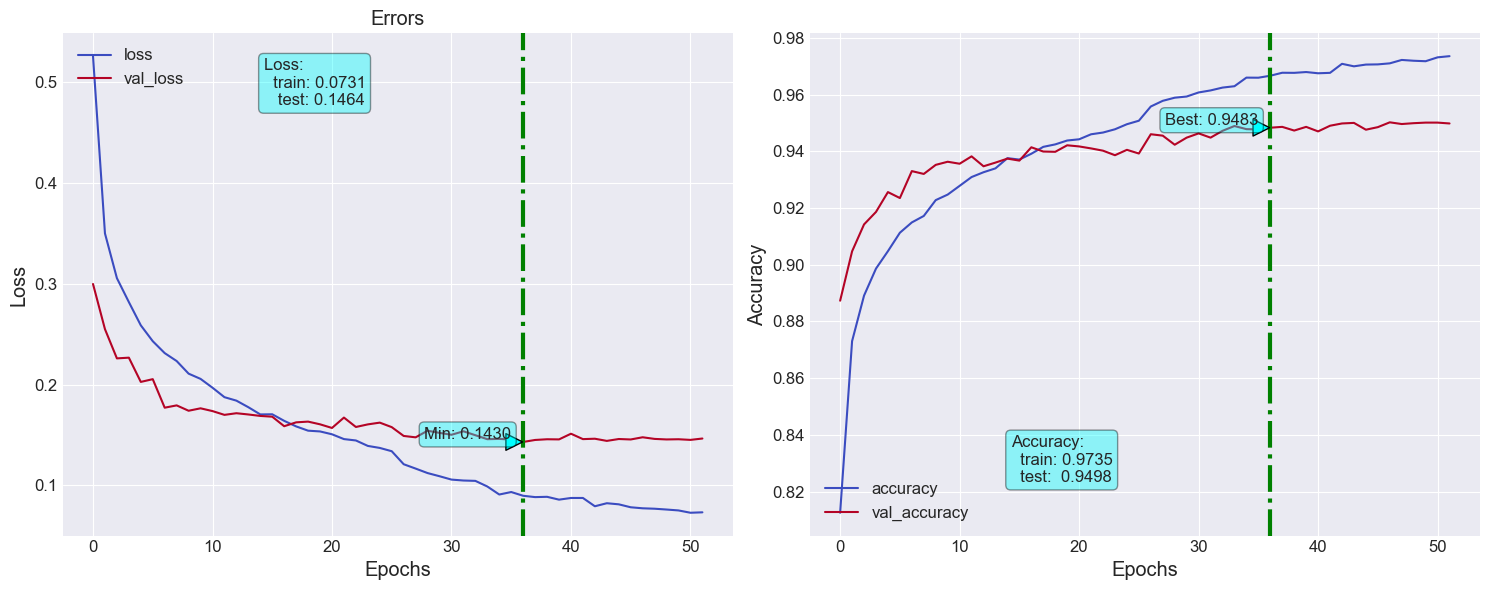

In [45]:
fn_plot_tf_hist(loss_df)

In [46]:
y_test = tf.concat([y for x,y in test_ds], axis=0).numpy()

y_hat = model.predict(test_ds)

y_pred = y_hat.argmax(axis=1)
y_pred.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


(10000,)

In [47]:
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred): .4f}') 

Accuracy:  0.9483


In [48]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       1.00      1.00      1.00      1000
           2       0.93      0.93      0.93      1000
           3       0.94      0.96      0.95      1000
           4       0.92      0.93      0.93      1000
           5       1.00      0.98      0.99      1000
           6       0.86      0.83      0.84      1000
           7       0.96      0.99      0.97      1000
           8       1.00      0.99      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



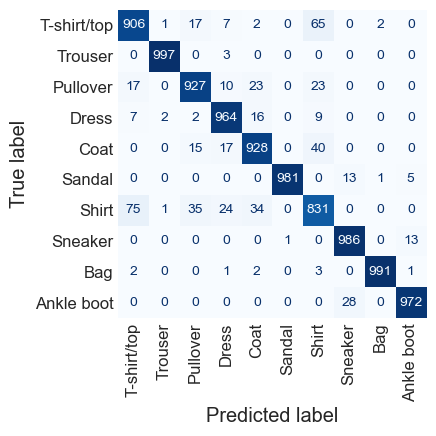

In [49]:

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names.values())
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax = ax, cmap='Blues', xticks_rotation = 'vertical', colorbar=False)
ax.grid(False)
plt.show()

In [50]:
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred): .4f}') 

Accuracy:  0.9483


In [51]:
# Function to filter examples where prediction differ from true labels
def filter_incorrect_predictions_batched(dataset, model):
    '''
    Args:
        dataset : tensorflow batched dataset
        model : tensorflow model
    Return:
    incorrect_samples (tuple) : (image, label, prediction)
    '''
    # to collect incorrect results
    incorrect_samples = []

    for batch_images, batch_labels in dataset:
        # Get predictions for the batch
        yhat = model.predict(batch_images)
        y_pred = yhat.argmax(axis = 1)

        # Compare predictions with true labels
        batch_labels_numpy = batch_labels.numpy()
        incorrect_indices = np.where(y_pred != batch_labels_numpy) [0] # Find incorrect

        # Extract incorrect samples from the batch
        for idx in incorrect_indices:
            incorrect_samples.append(
                (batch_images[idx].numpy(), batch_labels_numpy[idx], y_pred[idx])
                
            )
    return incorrect_samples

# Use the function to collect incorrect prediction
incorrect_examples = filter_incorrect_predictions_batched(test_ds, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [52]:
incorrect_examples[0][1]

2

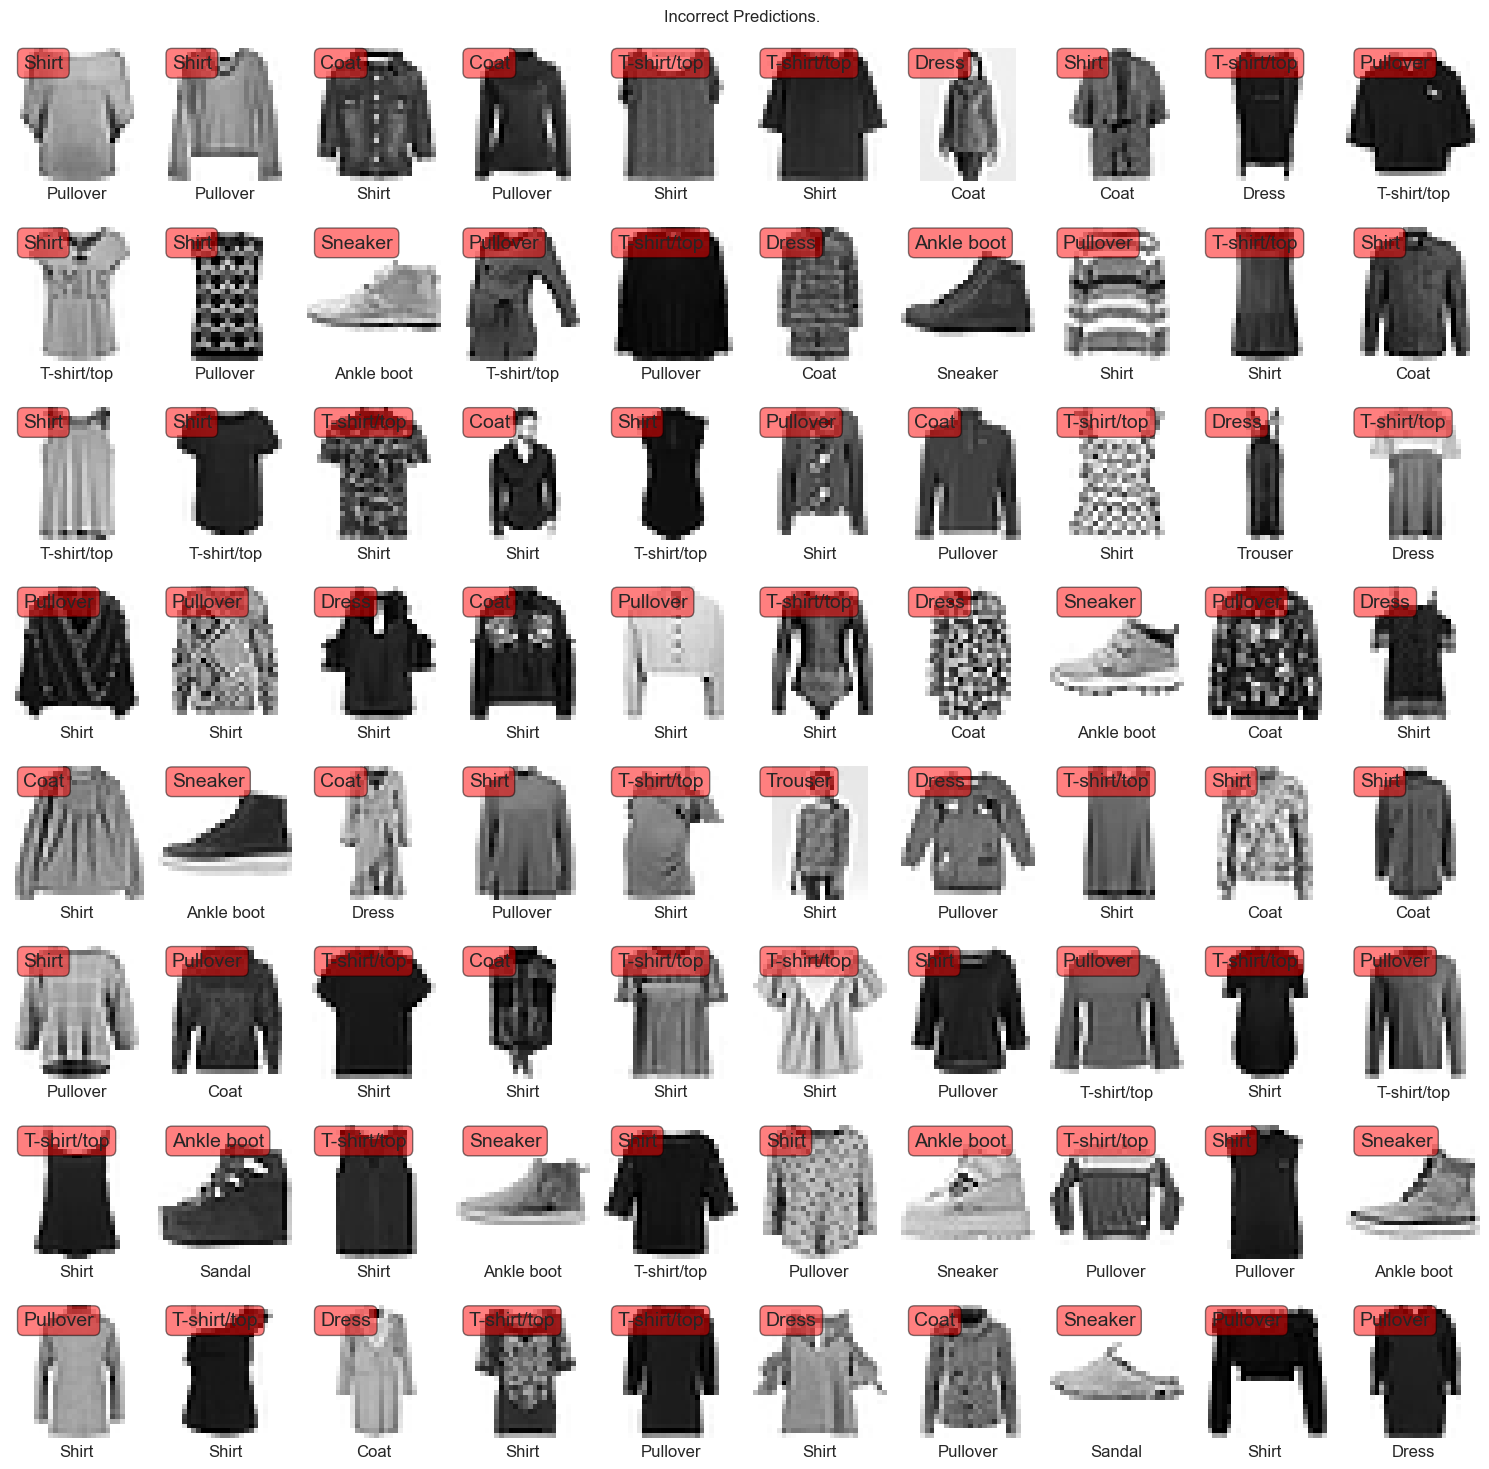

In [53]:
fig = plt.figure(figsize=(15, 15))

fig.subplots_adjust(left=0, right=1,
                   bottom=0, top=1,
                   hspace=0.05, wspace=0.05) # Adjus subplots

fntsize = 12

for i in range(80):
    image = incorrect_examples[i][0]
    label = incorrect_examples[i][1]
    pred = incorrect_examples[i][2]

    if label!=pred:
        color='red'
    else:
        color='cyan'

    prop = dict(boxstyle = 'round', facecolor=color, alpha=0.5)
    ax = fig.add_subplot(8, 10, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on axis
    ax.set_xlabel(class_names[label], fontsize=fntsize) # add number (class)
    ax.text(0.1, 0.95, class_names[pred], transform=ax.transAxes, fontsize=14,
           verticalalignment='top', bbox = prop ) # add number (class) of the image

fig.suptitle('Incorrect Predictions. ')
plt.tight_layout()
plt.show()